# Transformer Hawkes for Event Sequences

## Plan

- Theoretical notes
- Transformer Hawkes toy example
- Transformer Hawkes on the real world data

## Event sequences vs Classic Time Series in Neural Nets

### Classic Time Series

Data is synchronous, equally lagged

Data can be represented as a sequence of values $\{\mathbf{x}_i\}_{i=1}^N$ with the time lag $\Delta t$.

#### Question - What types of Neural Nets do we have for classic time series?



- Recurrent Neural Networks (RNN, LSTM, GRU)
    
    Pros:
    
    - Can catch temporal dependencies
    
    Cons:
    
    - Struggle to catch long term dependencies
    - Struggle from gradient vanishing and explosion
    - Cannot be paralleled

- CNNs for time series
    
    Pros:
    
    - Can be paralleled
    - Better captures long term dependencies
    
    Cons:
    
    - Enforce unnecessary dependencies

- Transformers
    
    Pros:
    
    - Can be paralled
    - Learn internal dependencies with attention mechanism

### Event Sequences

Data is asynchronous, unequally lagged

Data can be represented as a sequence of pairs $\{(t_i,c_i)\}_{i=1}^N$, one cannot provide the time lag and should take arrival times into account.

Neural Nets:

Should be similar, however, how can one take unequal lags into account?

## Training procedure

Let's assume that we sucessfully constructed some model $model(\mathbf{s}) \to \lambda(t|\mathcal{H})$. How can we train it?

Negative log-likelihood:
$$
\mathcal{L} = -\sum_{n=1}^N\left(\sum_{i=1}^{L_n}\log \lambda_{i}^n - \int_{0}^{T_n}\lambda(t|\mathcal{H}_n)\right)
$$

Our goal - minimize the loss.

What should we do with the integral?
- Monte Carlo integration
  $$
  \hat{\Lambda}_{MC} = \sum_{j=2}^L(t_j - t_{j-1})\left(\frac{1}{N}\sum_{i=1}^N \lambda(u_i)\right), ~ u_i \sim Unif(t_{j-1},t_j)
  $$
- Trapezoid integraion
  $$
  \hat{\Lambda}_{TR} = \sum_{j=2}^L\frac{t_j - t_{j-1}}{2}\left(\lambda(t_j|\mathcal{H}_{t_j}) + \lambda(t_{j-1}|\mathcal{H}_{t_{j-1}})\right)
  $$

Monte carlo integration will be more precise but will be more time consuming due to additional sampling.

Now we have the objective function.

We should design a model.

## Transformer Hawkes Model

https://arxiv.org/pdf/2002.09291.pdf

- Transformer are the state-of-the-art for seq2seq problems.
- Transformers can efficiently catch long term dependencies
- Transformers can be paralleled
- They are not designed for temporal point processes...

One can use embedding for event types and it will work with transformers. But what should we do with the arrival times?

**Solution**

Temporal encoding $(i\in\{1,\dots,M\})$

$$
[\mathbf{z}(t_j)]_i = \begin{cases}cos(t_j/10000^{\frac{i-1}{M}}), ~ \text{if} ~ i~\text{is odd}\\sin(t_j/10000^{i/M}), ~ \text{if} ~ i~\text{is even}\end{cases}
$$

Event encoding

$$
\mathbf{e}_j = \mathbf{U}\mathbf{c}_j
$$

$\mathbf{c}_j$ is an event one-hot encoding, $\mathbf{U}\in\mathbb{R}^{M\times C}$. $\mathbf{C} = [\mathbf{c}_1,\dots,\mathbf{c}_L]\in\mathbb{R}^{K\times L}$

Transformer input will be as follows:

$$
\mathbf{X} = (\mathbf{U}\mathbf{C} + \mathbf{Z})^{\top}
$$


**Architecture**

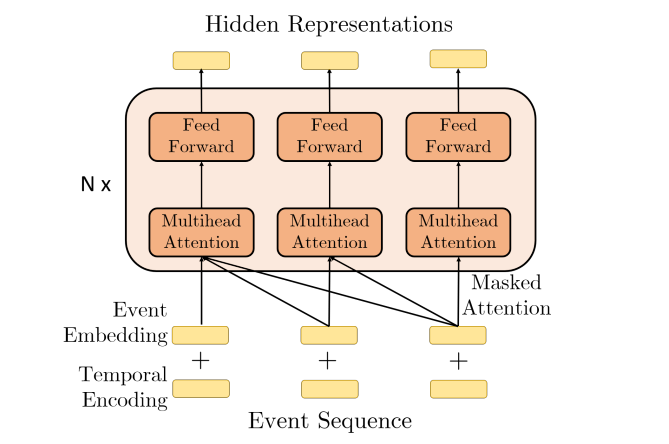

**Transformer Reminder**
    
Attention Score:
    
$$
    \mathbf{S} = \mathrm{Softmax}\left(\frac{\mathbf{Q}\mathbf{K}^{\top}}{\sqrt{M_K}}\right)\mathbf{V}
$$
    
$$
    \mathbf{Q} = \mathbf{X}\mathbf{W}^Q,~\mathbf{K} =\mathbf{X}\mathbf{W}^K,~\mathbf{V}=\mathbf{X}\mathbf{W}^V
$$
    
$$
    \mathbf{W}^Q,\mathbf{W}^K\in\mathbb{R}^{M\times M_{K}},~\mathbf{W}^V\in \mathbb{R}^{M\times M_V}
$$
    
Attention Scores for Multihead Attention: $\mathbf{S}_1,\dots,\mathbf{S}_H$.
    
Final attention output:
    
$$
    \mathbf{S} = [\mathbf{S}_1,\dots,\mathbf{S}_H]\mathbf{W}^O, ~ \mathbf{W}^O\in\mathbb{R}^{HM_V\times M}
$$
    
Attention is followed by the position-wise feed-forward neural network that consists of two linear layers. The resulting matrix is $\mathbf{H}\in\mathbb{R}^{L\times M}$.
    
The authors avoid peeking in the future by using masked attention.

Now, when we successfully introduced transformer model that can process event sequences, how can we predict the intensity?

In the paper authors proposed the following solution:

$$
\lambda_k(t|\mathcal{H}_t) = f_k\left(\alpha_k\frac{t-t_j}{t_j} + \mathbf{w}_k^{\top}\mathbf{h}(t_j) + b_k\right),~t\in[t_j,t_{j+1})\\f_k(u) = s_k\log(1+\exp(u/s_k))
$$

Terms:

- $\alpha_k\frac{t-t_j}{t_j}$ - current influence interpolation between observed timestamps $t_j$ and $t_{j+1}$
- $\mathbf{w}_k^{\top}\mathbf{h}(t_j)$ - the history term
- $b_k$ - the base intensity

Given this intensity once can find the expected arriving time and the event type as follows:

$$
p(t|\mathcal{H}_t) = \lambda(t|\mathcal{H}_t)\exp\left(-\int_{t_j}^t\lambda(\tau|\mathcal{H}_{\tau})d\tau\right)\\\hat{t}_{j+1} = \int_{t_j}^{+\infty}tp(t|\mathcal{H}_t)dt\\ \hat{c}_{j+1} = \arg\max_c \frac{\lambda_c(t_{j+1}|\mathcal{H}_{j+1})}{\lambda(t_{j+1}|\mathcal{H}_{j+1})}
$$

However, it is very tricky to compute the expectation of the return time. Thus, instead of computing this integral, authors propose to add additional linear layer and predict the return time directly.

## Transformer Hawkes Toy Example

We will use the following code source: https://github.com/SimiaoZuo/Transformer-Hawkes-Process

### Dataset Generation

Let's generate a dataset with the tick library with only one event type.

In [ ]:
!pip install tick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 28.6 MB/s 
     |████████████████████████████████| 51 kB 869 kB/s 
     |████████████████████████████████| 3.1 MB 54.4 MB/s 
     |████████████████████████████████| 84 kB 4.6 MB/s 
     |████████████████████████████████| 90 kB 11.6 MB/s 
     |████████████████████████████████| 121 kB 76.9 MB/s 
     |████████████████████████████████| 100 kB 12.7 MB/s 
  Attempting uninstall: sphinx
    Found existing installation: Sphinx 1.8.6
    Uninstalling Sphinx-1.8.6:
      Successfully uninstalled Sphinx-1.8.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
from tick.plot import plot_point_process
from tick.hawkes import SimuHawkes, HawkesKernelExp
import matplotlib.pyplot as plt
import torch

seed = 42
N = 1000
dataset = []

mu = 1.0
a = 0.35
delta = 0.7

for i in range(N):
  hawkes = SimuHawkes(n_nodes=1, max_jumps = 100, verbose=False, seed=seed + i)
  kernel = HawkesKernelExp(a/delta, delta)
  hawkes.set_kernel(0, 0, kernel)
  hawkes.set_baseline(0, mu)

  dt = 0.01
  hawkes.track_intensity(dt)
  hawkes.simulate()
  timestamps = hawkes.timestamps
  dataset.append(timestamps)

dataset = torch.Tensor(dataset)[:,0,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


### Multihead attention

Let's implement single head attention. We should use masked attention so that we do not peek into the future.

We will implement single head as a model for the simplicity of the realization. Indeed, it is better to vectorize multihead.

Let's implement:
```
class Attention(nn.Module):
  def __init__(self, M, M_K, M_V):
    super().__init__()
    self.M = M
    self.M_K = M_K
    self.M_V = M_V
```
Here `M` is an embedding size, `M_K` are query and key sizes and `M_V` is a value size.

The corresponding weights are:
```
    self.W_Q = Parameter(nn.init.xavier_uniform_(torch.zeros(M,M_K)))
    self.W_K = Parameter(nn.init.xavier_uniform_(torch.zeros(M,M_K)))
    self.W_V = Parameter(nn.init.xavier_uniform_(torch.zeros(M,M_V)))
```

Now let's implement the forward pass:
```
  def forward(self, X):
    bs, L, _ = X.shape
    Q = X @ self.W_Q
    K = X @ self.W_K
    V = X @ self.W_V

    pre_softmax = Q @ K.transpose(1,2) / self.M_K ** 0.5
```
Before applying softmax and computing scores we should mask the future. We will use -torch.inf that will always return 0 for softmax.
```
    mask = (torch.triu(torch.ones((L,L))) - torch.eye(L)).unsqueeze(0).repeat(bs,1,1)
    pre_softmax[mask == 1] = -torch.inf
    softmax = torch.softmax(pre_softmax, dim = 2)
    S = softmax @ V
    return S
```

In [ ]:
from torch.nn import Parameter
import torch.nn as nn

class Attention(nn.Module):
  def __init__(self, M, M_K, M_V):
    super().__init__()
    self.M = M
    self.M_K = M_K
    self.M_V = M_V

    self.W_Q = Parameter(nn.init.xavier_uniform_(torch.zeros(M,M_K)))
    self.W_K = Parameter(nn.init.xavier_uniform_(torch.zeros(M,M_K)))
    self.W_V = Parameter(nn.init.xavier_uniform_(torch.zeros(M,M_V)))

  def forward(self, X):
    bs, L, _ = X.shape
    Q = X @ self.W_Q
    K = X @ self.W_K
    V = X @ self.W_V

    pre_softmax = Q @ K.transpose(1,2) / self.M_K ** 0.5
    mask = (torch.triu(torch.ones((L,L))) - torch.eye(L)).unsqueeze(0).repeat(bs,1,1)
    pre_softmax[mask == 1] = -torch.inf
    softmax = torch.softmax(pre_softmax, dim = 2)
    S = softmax @ V
    return S

### Feed forward layer

Now let's implement the feedforward layer that should be used after the multihead attention.

This is just an additional layer that consists of two fully connected layers and ReLU.

In [ ]:
class FeedForwardLayer(nn.Module):
  def __init__(self, M, M_H):
    super().__init__()
    self.layer_1 = nn.Linear(M, M_H)
    self.layer_2 = nn.Linear(M_H, M)
    self.relu = nn.ReLU()

  def forward(self, S):
    return self.layer_2(self.relu(self.layer_1(S)))

### Transformer Model

#### Initialization

Now let's combine all the parts to the transformer model.

We will consider one event type transformer model.

First of all we should initialize several attention head. If you want, you can vectorize multihead on your own.

```
class TransformerHawkes(nn.Module):
  def __init__(self, M, M_K, M_V, M_H, num_of_attentions = 10):
    super().__init__()
    # transformer
    self.num_of_attentions = num_of_attentions
    for i in range(num_of_attentions):
      setattr(self,f'attention_{i}',Attention(M,M_K, M_V))
```

Then we should compute the output of the multihead attention approach:
```
    self.W_O = Parameter(nn.init.xavier_uniform_(torch.zeros(num_of_attentions*M_V,M)))
```

After that we should add the feedforward layer and final normalziation:
```
    self.feed_forward = FeedForwardLayer(M, M_H)
    self.layer_norm = nn.LayerNorm(M, eps=1e-6)
```

We should introduce parameter for final intensity computations, as you can remember these parameters are $\alpha$, $\mathbf{w}$ and $b$.

```
    # intensity prediction
    self.alpha = Parameter(torch.ones(1))
    self.w  = Parameter(torch.rand(M))
    self.b = Parameter(torch.ones(1))
```

Final activation
```
    self.sofplus = nn.Softplus()
```

#### Forward pass

Given the sequences and simulated times we want to compute lambdas and the integral.

First of all we should compute scores:

```
def forward(self, X, times, N = 100):
    """
    Returns lambda(t_i) and integral
    Note: ideally it should predict next arrival time, however we need only to prove the concept, so no need to implement this right now
    """
    scores = torch.concat([getattr(self, f'attention_{i}')(X) for i in range(self.num_of_attentions)], dim = 2)
```
Here N is the number of simulated times for Monte Carlo integration.

Then we should compute the hidden states of the transformer model:
```
    hiddens = scores @ self.W_O

    hiddens = hiddens + X

    hiddens = self.feed_forward(hiddens)
    hiddens = self.layer_norm(hiddens)
```

We will implement distinct methods for lambdas and integral computation, thus, here we can write:
```
    lambdas = self.get_lambdas_batch(hiddens, times)

    integral = self.get_integrals(hiddens, times, N)
    
    return lambdas, integral
```

#### Lambdas computation

For lambda computation we should implement two methods. `get_lambdas_batch(self, hiddens, times)` and `get_lambdas(self, t, hidden, t_j, simulated = False)`.

The first one is auxiliar and computes lambdas for batch. The second method is a general method that for given times to predict, hiddens and event times computes lambdas.

`get_lambdas_batch` preprocesses times and hiddens so that the format is good for `get_lambdas`. We have to predict the next event given all the previous events, thus we should define future times and past times and predict future times intensities given past times  and past hiddens:

```
  def get_lambdas_batch(self,hiddens, times):
    """
    Returns lambdas(t_i), i>=1
    """
    # code here
    future_times = times[:,1:]
    past_times = times[:,:-1]
    past_hiddens = hiddens[:,:-1,:]
    lambdas = self.get_lambdas(future_times, past_hiddens, past_times)
    return lambdas
```

We should predict the intensity in `get_lambdas`, we will use the formula from the transformer hawkes paper:
```
  def get_lambdas(self, t, hidden, t_j, simulated = False):
    if simulated:
      t_j = t_j.unsqueeze(2).repeat(1,1,t.shape[2])
    assert torch.all(t >= t_j)
    history = hidden @ self.w
    if simulated:
      history = history.unsqueeze(2)
    tmp = self.alpha * (t - t_j)/t_j + history + self.b
    out = self.softplus(tmp)
    return out
```

#### Integral computation

To compute the integral we should generate additional times and compute lambdas for them. Then we should apply the $\Lambda_{MC}$ formula.

Computing $t_j - t_{j-1}$ for each timestamps:
```
  def get_integrals(self, hiddens, times, N):
    """
    Returns integrals per element in batch, shape = (bs,)
    """
    # code here
    future_times = times[:,1:]
    past_times = times[:,:-1]
    past_hiddens = hiddens[:,:-1,:]
    delta_times = future_times - past_times
```

Simulating times:
```
    bs, L = delta_times.shape
    sumulated_times = torch.rand(bs, L, N)*delta_times.unsqueeze(2)+ past_times.unsqueeze(2)
```
Computing lambdas for simulated times:
```
    simulated_lambdas = self.get_lambdas(sumulated_times, past_hiddens, past_times, True)
    integral = torch.sum(delta_times * torch.sum(simulated_lambdas / N, dim = 2), dim = 1)
    return integral
```

#### Code

In [ ]:
class TransformerHawkes(nn.Module):
  def __init__(self, M, M_K, M_V, M_H, num_of_attentions = 10):
    super().__init__()
    # transformer
    self.num_of_attentions = num_of_attentions
    for i in range(num_of_attentions):
      setattr(self,f'attention_{i}',Attention(M,M_K, M_V))
    self.W_O = Parameter(nn.init.xavier_uniform_(torch.zeros(num_of_attentions*M_V,M)))
    self.feed_forward = FeedForwardLayer(M, M_H)
    self.layer_norm = nn.LayerNorm(M, eps=1e-6)

    # intensity prediction
    self.alpha = Parameter(torch.ones(1))
    self.w  = Parameter(torch.rand(M))
    self.b = Parameter(torch.ones(1))

    # utils
    self.softplus = nn.Softplus()

  def forward(self, X, times, N = 100):
    """
    Returns lambda(t_i) and integral
    Note: ideally it should predict next arrival time, however we need only to prove the concept, so no need to implement this right now
    """
    scores = torch.concat([getattr(self, f'attention_{i}')(X) for i in range(self.num_of_attentions)], dim = 2)
    hiddens = scores @ self.W_O

    hiddens = hiddens + X

    hiddens = self.feed_forward(hiddens)
    hiddens = self.layer_norm(hiddens)

    lambdas = self.get_lambdas_batch(hiddens, times)

    integral = self.get_integrals(hiddens, times, N)

    return lambdas, integral

  def get_lambdas_batch(self,hiddens, times):
    """
    Returns lambdas(t_i), i>=1
    """
    future_times = times[:,1:]
    past_times = times[:,:-1]
    past_hiddens = hiddens[:,:-1,:]
    lambdas = self.get_lambdas(future_times, past_hiddens, past_times)
    return lambdas

  def get_integrals(self, hiddens, times, N):
    """
    Returns integrals per element in batch, shape = (bs,)
    """
    future_times = times[:,1:]
    past_times = times[:,:-1]
    past_hiddens = hiddens[:,:-1,:]
    delta_times = future_times - past_times
    bs, L = delta_times.shape
    sumulated_times = torch.rand(bs, L, N)*delta_times.unsqueeze(2)+ past_times.unsqueeze(2)
    simulated_lambdas = self.get_lambdas(sumulated_times, past_hiddens, past_times, True)
    integral = torch.sum(delta_times * torch.sum(simulated_lambdas / N, dim = 2), dim = 1)
    return integral


  def get_lambdas(self, t, hidden, t_j, simulated = False):
    if simulated:
      t_j = t_j.unsqueeze(2).repeat(1,1,t.shape[2])
    assert torch.all(t >= t_j)
    history = hidden @ self.w
    if simulated:
      history = history.unsqueeze(2)
    tmp = self.alpha * (t - t_j)/t_j + history + self.b
    out = self.softplus(tmp)
    return out

### Temporal Encoding

We should also implement the temporal encoding. We should implement the `Dataset` class with `__getitem__` and `__len__` methods.

Given times and the embedding size we compute temporal encoding:

```
    self.z = torch.arange(0,M)[None,None,:].repeat(self.N,self.L,1)
    self.z = torch.cos(
              self.times.unsqueeze(2)/10000**((self.z - 1)/M)
            ) * (self.z % 2 == 1) \
           + torch.sin(
              self.times.unsqueeze(2)/10000**(self.z/M)
            ) * (self.z % 2 == 0)
```

In [ ]:
from torch.utils.data import Dataset

class Embeddings(Dataset):
  def __init__(self, times, M):
    """Temporal encoding only"""
    self.N, self.L = times.shape
    self.times = times
    self.z = torch.arange(0,M)[None,None,:].repeat(self.N,self.L,1)
    self.z = torch.cos(
              self.times.unsqueeze(2)/10000**((self.z - 1)/M)
            ) * (self.z % 2 == 1) \
           + torch.sin(
              self.times.unsqueeze(2)/10000**(self.z/M)
            ) * (self.z % 2 == 0)


  def __getitem__(self, index):
    return self.times[index, ...], self.z[index, ...]

  def __len__(self):
    return self.N

### Training

#### Preparation

Now let's train.

In [ ]:
import numpy as np

def train(model, ref_model, train_loader, optimizer, epoch):
    model.train()
    ll = []
    mse_lambdas = []
    for batch_idx, (times, batch) in enumerate(train_loader):
        optimizer.zero_grad()
        lambdas, integral = model(batch, times)
        ref_lambdas = ref_model.lambdas(times)[:,1:]
        mse_lambdas.append(torch.mean((lambdas - ref_lambdas)**2).item())
        negative_ll = - torch.sum(torch.log(lambdas + 1e-8)) + torch.sum(integral)
        negative_ll.backward()
        optimizer.step()
        ll.append(negative_ll.item())
    return np.mean(ll), np.mean(mse_lambdas)

Reference model so that we could compare the predicted intensity.

In [ ]:
class Hawkes(torch.nn.Module):
  def __init__(self, L, init_mu = 0.1, init_a = 0.1, init_delta = 0.1):
    super().__init__()
    self.mu = torch.nn.Parameter(init_mu*torch.ones(1))
    self.a = torch.nn.Parameter(init_a*torch.ones(1))
    self.delta = torch.nn.Parameter(init_delta*torch.ones(1))
    self.L = L
    self.V = torch.tril(torch.ones((L,L)), diagonal=-1)
    self.V = self.V.unsqueeze(0)

  def forward(self, batch):
    """
    Returns loss
    Note: ideally it should predict next arrival time, however we need only to prove the concept, so no need to implement this right now
    """
    # events
    lambda_loss = - torch.sum(torch.log(self.lambdas(batch)))

    # non events
    integral_loss = self.integral(batch)

    return lambda_loss + integral_loss

  def lambdas(self, batch):
    """Returns lambda(t_{i,j}) for all i, j (do not sum, we will use this function later)"""
    S = batch.unsqueeze(2).repeat(1,1,self.L)
    S = S - S.transpose(1,2)
    lambdas = self.mu + torch.sum(torch.exp(-self.delta * S) * (self.a * self.V), dim = 2)
    return lambdas

  def integral(self, batch):
    """Returns integral loss (do not forget to sum)"""
    base = self.mu * batch[:, -1]
    last = batch[:,-1].unsqueeze(1).repeat(1,self.L)
    exps = (self.a - self.a * torch.exp(-self.delta * (last - batch)))/self.delta

    integral_loss = torch.sum(base) + torch.sum(exps)
    return integral_loss

  def __str__(self):
    return "lambda = {:.3f} + sum {:.3f} * exp( - {:.3f} (t - t_i))".format(self.mu.detach().numpy()[0], self.a.detach().numpy()[0], self.delta.detach().numpy()[0])

#### Training

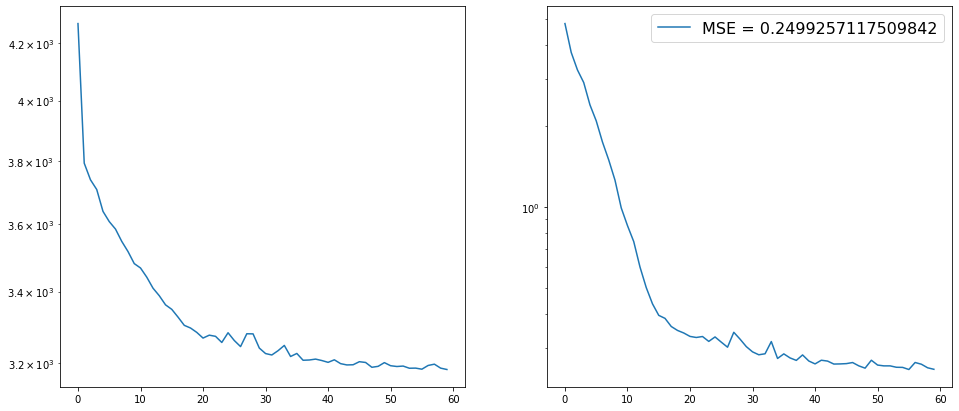

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

dataset_with_embeddings = Embeddings(dataset, 16)

ref_model = Hawkes(100, 1.0, 0.35, 0.7)
model = TransformerHawkes(16,32,32,32,5)
batch_size = 100

train_dataloader = torch.utils.data.DataLoader(dataset_with_embeddings, batch_size = batch_size, num_workers = 0, pin_memory = True, shuffle = True)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2, weight_decay=1e-5)

losses = []
mse_lambdas = []

for epoch in range(60):
  clear_output(wait=True)
  l,m = train(model, ref_model, train_dataloader, optimizer, epoch)
  losses.append(l)
  mse_lambdas.append(m)

  fig, axes = plt.subplots(1, 2, figsize=(16,7))
  axes[0].plot(losses)
  axes[0].set_yscale('log')
  axes[1].plot(mse_lambdas, label = "MSE = {}".format(m))
  axes[1].set_yscale('log')
  axes[1].legend(fontsize=16, loc="upper right", bbox_to_anchor=(1,1))
  plt.show()

### Transformer model generalization discussion

#### Question - what should we change, so that we could work with event sequneces with multiple event types and different sequence lengths?

- We should add event types sequence to the Dataset with ```self.event_types``` and check that we do not have 0 as an event type otherwise shift event_types labels (```self.event_types += 1```).
- We should add ```nn.Embedding(num_embeddings, embedding_dim, padding_idx=0)``` and add the output of this layer to the time embeddings.
- We should use zero padding with ```torch.nn.functional.pad```, to account different lengths and ignore these values in the transformer.
- We should change
```
self.alpha = Parameter(torch.ones(1))
self.w  = Parameter(torch.rand(M))
self.b = Parameter(torch.ones(1))
```
to
```
self.alpha = Parameter(torch.ones(n_types))
self.w  = Parameter(torch.rand(M,n_types))
self.b = Parameter(torch.ones(n_types))
```
and use the corresponding intensity in $\sum \log \lambda_{c_i}(t_i)$


Instead of implementing the model from scratch we will use the following implementation https://github.com/SimiaoZuo/Transformer-Hawkes-Process

## Real World Data experiments

### Loading Data

First of all we should load the data that we will use for training.

In [ ]:
!pip install googledrivedownloader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1i3NI7zKjaTzrPLi1IPVWAiFjXjch8oc2',
                                    dest_path='./train.pkl')

gdd.download_file_from_google_drive(file_id='1q1VUY3VTmaZqT8VjWY5hKrSx8v9tZbt7',
                                    dest_path='./train_tick.pkl')

This is the tweets dataset with tweets action history. Let's open the file.

In [ ]:
!pip install pickle-mixin --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=6006 sha256=bae734e5535823dff733efe72b31ab64722c504bd26bbe6028952bb145fa30ac
  Stored in directory: /root/.cache/pip/wheels/58/c6/8b/061bd4edc8cea2b2235758c3e50473d08499236fbfdd21e6b3
Successfully built pickle-mixin


In [ ]:
import pickle
with open('./train.pkl','rb') as f:
  train_dset = pickle.load(f)

In [ ]:
train_dset.keys()

dict_keys([b'test1', b'args', b'dim_process', b'dev', b'train', b'test'])

In [ ]:
train_dset[b'train'][0]

[{b'time_since_start': 15.0, b'time_since_last_event': 15.0, b'type_event': 1},
 {b'time_since_start': 16.0, b'time_since_last_event': 1.0, b'type_event': 1},
 {b'time_since_start': 19.0, b'time_since_last_event': 3.0, b'type_event': 1},
 {b'time_since_start': 23.0, b'time_since_last_event': 4.0, b'type_event': 1},
 {b'time_since_start': 23.0, b'time_since_last_event': 0.0, b'type_event': 0},
 {b'time_since_start': 25.0, b'time_since_last_event': 2.0, b'type_event': 1},
 {b'time_since_start': 28.0, b'time_since_last_event': 3.0, b'type_event': 0},
 {b'time_since_start': 30.0, b'time_since_last_event': 2.0, b'type_event': 0},
 {b'time_since_start': 32.0, b'time_since_last_event': 2.0, b'type_event': 0},
 {b'time_since_start': 33.0, b'time_since_last_event': 1.0, b'type_event': 0},
 {b'time_since_start': 34.0, b'time_since_last_event': 1.0, b'type_event': 0},
 {b'time_since_start': 36.0, b'time_since_last_event': 2.0, b'type_event': 0},
 {b'time_since_start': 39.0, b'time_since_last_even

Here we only need the 'train' key, 'test', 'dev' and 'test1' are empty, this data in other files.

The number of event types is three.

In [ ]:
train_dset[b'dim_process']

3

### Tick Training

In [ ]:
with open('./train_tick.pkl', 'rb') as f:
  tick_dset = pickle.load(f)

Let's use nonparametric Hawkes model

In [ ]:
len(tick_dset)

20000

In [ ]:
tick_dset[1]

[array([1.40000e+01, 2.20000e+01, 2.50000e+01, 8.30000e+01, 9.30000e+01,
        9.90000e+01, 1.41000e+02, 1.66000e+02, 2.55000e+02, 3.25000e+02,
        3.90000e+02, 4.05000e+02, 4.64000e+02, 4.89000e+02, 5.80000e+02,
        6.48000e+02, 1.29500e+03, 1.29800e+03, 1.77200e+03, 1.86900e+03,
        2.07500e+03, 2.18400e+03, 2.37300e+03, 3.04800e+03, 3.12600e+03,
        4.30800e+03, 5.11600e+03, 5.25100e+03, 5.48200e+03, 6.53700e+03,
        9.49300e+03, 1.29140e+04, 1.33560e+04, 1.36220e+04, 1.39660e+04,
        1.70640e+04, 2.63890e+04, 2.65550e+04, 2.99210e+04, 3.04130e+04,
        3.12950e+04, 3.74210e+04, 4.90970e+04, 5.74800e+04, 9.34570e+04,
        9.34570e+04, 1.08301e+05, 1.23679e+05, 1.26921e+05, 2.71133e+05]),
 array([4.70000e+01, 5.00000e+01, 8.80000e+01, 8.90000e+01, 1.63000e+02,
        2.91000e+02, 3.82000e+02, 4.95000e+02, 8.91000e+02, 1.43900e+03,
        4.10900e+03, 5.08200e+03, 5.54500e+03, 1.30990e+04, 2.16660e+04,
        2.91760e+04, 3.04270e+04, 3.13030e+04, 3.

In [ ]:
!pip install tick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tick
from tick.hawkes import HawkesEM

em = HawkesEM(3200, kernel_size=50, n_threads=8, verbose=True, tol=1e-3)
em.fit(tick_dset[:1000])

Let's take a look at the kernels.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tick.hawkes import (SimuHawkes, HawkesKernelTimeFunc, HawkesKernelExp,
                         HawkesEM)
from tick.base import TimeFunction
from tick.plot import plot_hawkes_kernels
%matplotlib inline


fig = plot_hawkes_kernels(em, show=False)

The log likelihood per event is as follow.

Train

In [ ]:
em.score(tick_dset[:1000])/sum([sum([len(j) for j in i]) for i in tick_dset[:1000]])

Validation

In [ ]:
em.score(tick_dset[1000:2000])/sum([sum([len(j) for j in i]) for i in tick_dset[1000:2000]])

### Transfromer Hawkes

#### Multihead attention

Multihead attention is implemented with two classes. The first one `ScaledDotProductAttention` is auxiliar class for final attention score computations. It computes attention scores given queries, keys and values.

`MultiHeadAttention` is the main attention class that takes input tensors and returns attention output and scores. Here the arguments of forward pass `forward(self, q, k, v, mask=None)` takes `q`, `k` and `v`, they will be identical in the Encoder.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class ScaledDotProductAttention(nn.Module):
    """ Scaled Dot-Product Attention """

    def __init__(self, temperature, attn_dropout=0.2):
        super().__init__()

        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):
        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn


class MultiHeadAttention(nn.Module):
    """ Multi-Head Attention module """

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1, normalize_before=True):
        super().__init__()

        self.normalize_before = normalize_before
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        nn.init.xavier_uniform_(self.w_qs.weight)
        nn.init.xavier_uniform_(self.w_ks.weight)
        nn.init.xavier_uniform_(self.w_vs.weight)

        self.fc = nn.Linear(d_v * n_head, d_model)
        nn.init.xavier_uniform_(self.fc.weight)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5, attn_dropout=dropout)

        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q
        if self.normalize_before:
            q = self.layer_norm(q)

        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)  # For head axis broadcasting.

        output, attn = self.attention(q, k, v, mask=mask)

        # Transpose to move the head dimension back: b x lq x n x dv
        # Combine the last two dimensions to concatenate all the heads together: b x lq x (n*dv)
        output = output.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        output = self.dropout(self.fc(output))
        output += residual

        if not self.normalize_before:
            output = self.layer_norm(output)
        return output, attn

#### Feedforward layer

Now we should implement two-layer feed-forward network with dropout.

In [ ]:
class PositionwiseFeedForward(nn.Module):
    """ Two-layer position-wise feed-forward neural network. """

    def __init__(self, d_in, d_hid, dropout=0.1, normalize_before=True):
        super().__init__()

        self.normalize_before = normalize_before

        self.w_1 = nn.Linear(d_in, d_hid)
        self.w_2 = nn.Linear(d_hid, d_in)

        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        if self.normalize_before:
            x = self.layer_norm(x)

        x = F.gelu(self.w_1(x))
        x = self.dropout(x)
        x = self.w_2(x)
        x = self.dropout(x)
        x = x + residual

        if not self.normalize_before:
            x = self.layer_norm(x)
        return x

#### Encoder Layer

Let's combine implemneted layers and construct Encoder layer.

Here you can see that Encoder layer takes exactly one encoder_input and sends it to attention mechanism. Also it takes two masks. The first mask indicates true sequence values and we need it to zero everything that corresponds to zero padding. The second one indicates values that we need to mask so that the model doesn't peek into future.

In [ ]:
class EncoderLayer(nn.Module):
    """ Compose with two layers """

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1, normalize_before=True):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(
            n_head, d_model, d_k, d_v, dropout=dropout, normalize_before=normalize_before)
        self.pos_ffn = PositionwiseFeedForward(
            d_model, d_inner, dropout=dropout, normalize_before=normalize_before)

    def forward(self, enc_input, non_pad_mask=None, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
        enc_output *= non_pad_mask

        enc_output = self.pos_ffn(enc_output)
        enc_output *= non_pad_mask

        return enc_output, enc_slf_attn

#### Utils functions

Additional funciton that we need for our model.

`get_non_pad_mask` return the non-padding positions.

`get_attn_key_pad_mask` same, but for key sequence.

`get_subsequent_mask` computes mask that is needed for future masking, so that our model doesn't peek into the future.

In [ ]:
def get_non_pad_mask(seq):
    """ Get the non-padding positions. """

    assert seq.dim() == 2
    return seq.ne(0).type(torch.float).unsqueeze(-1)


def get_attn_key_pad_mask(seq_k, seq_q):
    """ For masking out the padding part of key sequence. """

    # expand to fit the shape of key query attention matrix
    len_q = seq_q.size(1)
    padding_mask = seq_k.eq(0)
    padding_mask = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # b x lq x lk
    return padding_mask


def get_subsequent_mask(seq):
    """ For masking out the subsequent info, i.e., masked self-attention. """

    sz_b, len_s = seq.size()
    subsequent_mask = torch.triu(
        torch.ones((len_s, len_s), device=seq.device, dtype=torch.uint8), diagonal=1)
    subsequent_mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls
    return subsequent_mask

#### Encoder

Now we should implement multilayer encoder.

In [ ]:
import math

class Encoder(nn.Module):
    """ A encoder model with self attention mechanism. """

    def __init__(
            self,
            num_types, d_model, d_inner,
            n_layers, n_head, d_k, d_v, dropout):
        super().__init__()

        self.d_model = d_model

        # position vector, used for temporal encoding
        self.position_vec = torch.tensor(
            [math.pow(10000.0, 2.0 * (i // 2) / d_model) for i in range(d_model)],
            device=torch.device('cuda'))

        # event type embedding
        self.event_emb = nn.Embedding(num_types + 1, d_model, padding_idx=0)

        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout, normalize_before=False)
            for _ in range(n_layers)])

    def temporal_enc(self, time, non_pad_mask):
        """
        Input: batch*seq_len.
        Output: batch*seq_len*d_model.
        """

        result = time.unsqueeze(-1) / self.position_vec
        result[:, :, 0::2] = torch.sin(result[:, :, 0::2])
        result[:, :, 1::2] = torch.cos(result[:, :, 1::2])
        return result * non_pad_mask

    def forward(self, event_type, event_time, non_pad_mask):
        """ Encode event sequences via masked self-attention. """

        # prepare attention masks
        # slf_attn_mask is where we cannot look, i.e., the future and the padding
        slf_attn_mask_subseq = get_subsequent_mask(event_type)
        slf_attn_mask_keypad = get_attn_key_pad_mask(seq_k=event_type, seq_q=event_type)
        slf_attn_mask_keypad = slf_attn_mask_keypad.type_as(slf_attn_mask_subseq)
        slf_attn_mask = (slf_attn_mask_keypad + slf_attn_mask_subseq).gt(0)

        tem_enc = self.temporal_enc(event_time, non_pad_mask)
        enc_output = self.event_emb(event_type)

        for enc_layer in self.layer_stack:
            enc_output += tem_enc
            enc_output, _ = enc_layer(
                enc_output,
                non_pad_mask=non_pad_mask,
                slf_attn_mask=slf_attn_mask)
        return enc_output

#### Transformer Model

Now let's construct the Transformer model. We won't predict return time and event type now and will focus on the negative log-likelihood comparison with the baseline model.

In [ ]:
class Transformer(nn.Module):
    """ A sequence to sequence model with attention mechanism. """

    def __init__(
            self,
            num_types, d_model=256, d_inner=1024,
            n_layers=4, n_head=4, d_k=64, d_v=64, dropout=0.1):
        super().__init__()

        self.encoder = Encoder(
            num_types=num_types,
            d_model=d_model,
            d_inner=d_inner,
            n_layers=n_layers,
            n_head=n_head,
            d_k=d_k,
            d_v=d_v,
            dropout=dropout,
        )

        self.num_types = num_types

        # convert hidden vectors into a scalar
        self.linear = nn.Linear(d_model, num_types)

        # parameter for the weight of time difference
        self.alpha = nn.Parameter(torch.tensor(-0.1))

        # parameter for the softplus function
        self.beta = nn.Parameter(torch.tensor(1.0))

    def forward(self, event_type, event_time):
        """
        Return the hidden representations and predictions.
        For a sequence (l_1, l_2, ..., l_N), we predict (l_2, ..., l_N, l_{N+1}).
        Input: event_type: batch*seq_len;
               event_time: batch*seq_len.
        Output: enc_output: batch*seq_len*model_dim;
                type_prediction: batch*seq_len*num_classes (not normalized);
                time_prediction: batch*seq_len.
        """

        non_pad_mask = get_non_pad_mask(event_type)

        enc_output = self.encoder(event_type, event_time, non_pad_mask)

        return enc_output

#### Dataset

Here we introduce classes and function to setup dataloader.

In [ ]:
class EventData(torch.utils.data.Dataset):
    """ Event stream dataset. """

    def __init__(self, data):
        """
        Data should be a list of event streams; each event stream is a list of dictionaries;
        each dictionary contains: time_since_start, time_since_last_event, type_event
        """
        self.time = [[elem[b'time_since_start'] for elem in inst] for inst in data]
        self.time_gap = [[elem[b'time_since_last_event'] for elem in inst] for inst in data]
        # plus 1 since there could be event type 0, but we use 0 as padding
        self.event_type = [[elem[b'type_event'] + 1 for elem in inst] for inst in data]

        self.length = len(data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        """ Each returned element is a list, which represents an event stream """
        return self.time[idx], self.time_gap[idx], self.event_type[idx]


def pad_time(insts):
    """ Pad the instance to the max seq length in batch. """

    max_len = max(len(inst) for inst in insts)

    batch_seq = np.array([
        inst + [0] * (max_len - len(inst))
        for inst in insts])

    return torch.tensor(batch_seq, dtype=torch.float32)


def pad_type(insts):
    """ Pad the instance to the max seq length in batch. """

    max_len = max(len(inst) for inst in insts)

    batch_seq = np.array([
        inst + [0] * (max_len - len(inst))
        for inst in insts])

    return torch.tensor(batch_seq, dtype=torch.long)


def collate_fn(insts):
    """ Collate function, as required by PyTorch. """

    time, time_gap, event_type = list(zip(*insts))
    time = pad_time(time)
    time_gap = pad_time(time_gap)
    event_type = pad_type(event_type)
    return time, time_gap, event_type


def get_dataloader(data, batch_size, shuffle=True):
    """ Prepare dataloader. """

    ds = EventData(data)
    dl = torch.utils.data.DataLoader(
        ds,
        num_workers=2,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle
    )
    return dl

#### Log-likelihood computation

In [ ]:
def softplus(x, beta):
    # hard thresholding at 20
    temp = beta * x
    temp[temp > 20] = 20
    return 1.0 / beta * torch.log(1 + torch.exp(temp))


def compute_event(event, non_pad_mask):
    """ Log-likelihood of events. """

    # add 1e-9 in case some events have 0 likelihood
    event += math.pow(10, -9)
    event.masked_fill_(~non_pad_mask.bool(), 1.0)

    result = torch.log(event)
    return result


def compute_integral_biased(all_lambda, time, non_pad_mask):
    """ Log-likelihood of non-events, using linear interpolation. """

    diff_time = (time[:, 1:] - time[:, :-1]) * non_pad_mask[:, 1:]
    diff_lambda = (all_lambda[:, 1:] + all_lambda[:, :-1]) * non_pad_mask[:, 1:]

    biased_integral = diff_lambda * diff_time
    result = 0.5 * biased_integral
    return result


def compute_integral_unbiased(model, data, time, non_pad_mask, type_mask):
    """ Log-likelihood of non-events, using Monte Carlo integration. """

    num_samples = 100

    diff_time = (time[:, 1:] - time[:, :-1]) * non_pad_mask[:, 1:]
    temp_time = diff_time.unsqueeze(2) * \
                torch.rand([*diff_time.size(), num_samples], device=data.device)
    temp_time /= (time[:, :-1] + 1).unsqueeze(2)

    temp_hid = model.linear(data)[:, 1:, :]
    temp_hid = torch.sum(temp_hid * type_mask[:, 1:, :], dim=2, keepdim=True)

    all_lambda = softplus(temp_hid + model.alpha * temp_time, model.beta)
    all_lambda = torch.sum(all_lambda, dim=2) / num_samples

    unbiased_integral = all_lambda * diff_time
    return unbiased_integral


def log_likelihood(model, data, time, types):
    """ Log-likelihood of sequence. """

    non_pad_mask = get_non_pad_mask(types).squeeze(2)

    type_mask = torch.zeros([*types.size(), model.num_types], device=data.device)
    for i in range(model.num_types):
        type_mask[:, :, i] = (types == i + 1).bool().to(data.device)

    all_hid = model.linear(data)
    all_lambda = softplus(all_hid, model.beta)
    type_lambda = torch.sum(all_lambda * type_mask, dim=2)

    # event log-likelihood
    event_ll = compute_event(type_lambda, non_pad_mask)
    event_ll = torch.sum(event_ll, dim=-1)

    # non-event log-likelihood, either numerical integration or MC integration
    # non_event_ll = compute_integral_biased(type_lambda, time, non_pad_mask)
    non_event_ll = compute_integral_unbiased(model, data, time, non_pad_mask, type_mask)
    non_event_ll = torch.sum(non_event_ll, dim=-1)

    return event_ll, non_event_ll

#### Training

In [ ]:
def train(model, train_loader, optimizer, epoch, device):
    model.train()
    ll = []
    for batch_idx, (times, _, event_types) in enumerate(train_loader):
        optimizer.zero_grad()
        times, event_types = times.to(device), event_types.to(device)
        enc_out = model(event_types, times)
        event_ll, non_event_ll = log_likelihood(model, enc_out, times, event_types)
        log_likelihood_value = torch.sum(event_ll - non_event_ll)
        ll_per_event = log_likelihood_value.cpu().item()/torch.sum(get_non_pad_mask(event_types)).cpu()
        ll.append(float(ll_per_event))
        negative_ll = - log_likelihood_value
        negative_ll.backward()
        optimizer.step()
    return np.mean(ll)

def validate(model, val_loader, epoch, device):
    model.eval()
    ll = []
    for batch_idx, (times, _, event_types) in enumerate(val_loader):
        times, event_types = times.to(device), event_types.to(device)
        enc_out = model(event_types, times)
        event_ll, non_event_ll = log_likelihood(model, enc_out, times, event_types)
        log_likelihood_value = torch.sum(event_ll - non_event_ll)
        ll_per_event = log_likelihood_value.cpu().item()/torch.sum(get_non_pad_mask(event_types)).cpu()
        ll.append(float(ll_per_event))
    return np.mean(ll)

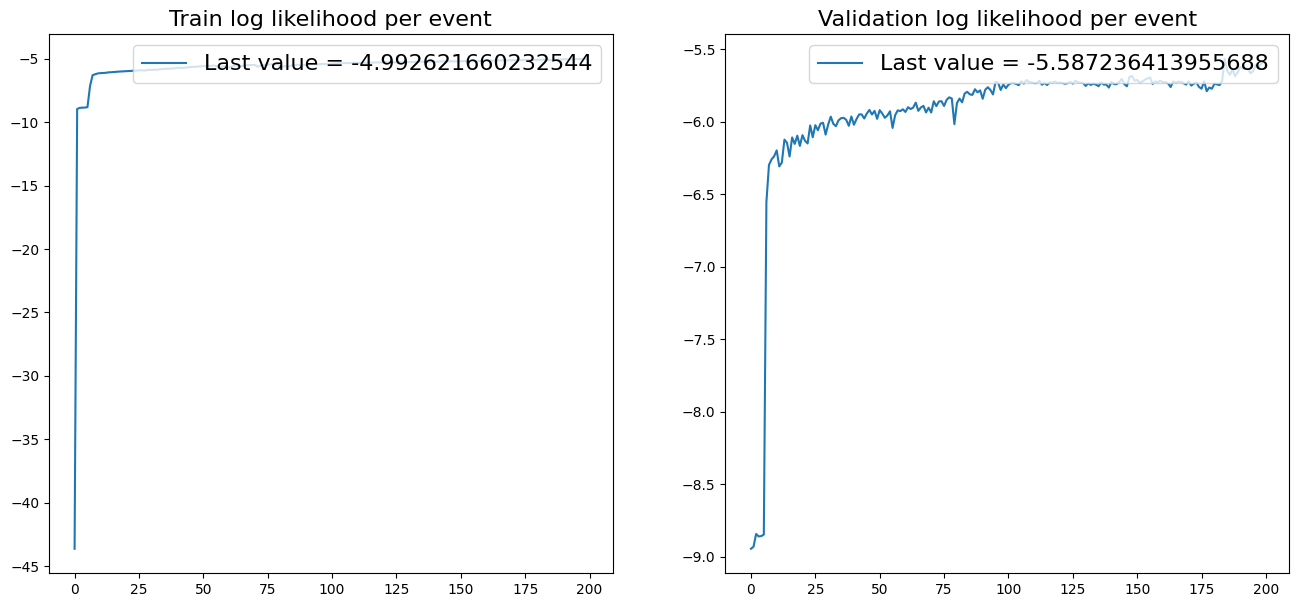

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

train_dataloader = get_dataloader(train_dset[b'train'][:1000], 20, True)
validation_dataloader = get_dataloader(train_dset[b'train'][1000:2000], 20)

device = 'cuda'
model = Transformer(3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2, weight_decay=1e-5)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=20, threshold=0.001)

losses = []
losses_val = []

for epoch in range(200):
  clear_output(wait=True)
  l = train(model, train_dataloader, optimizer, epoch, device)
  lv = validate(model, validation_dataloader, epoch, device)
  losses.append(l)
  losses_val.append(lv)
  sch.step(-l)

  fig, axes = plt.subplots(1, 2, figsize=(16,7))
  axes[0].plot(losses, label = "Last value = {}".format(l))
  axes[0].legend(fontsize=16, loc="upper right", bbox_to_anchor=(1,1))
  axes[0].set_title('Train log likelihood per event', fontsize=16)
  axes[1].plot(losses_val, label = "Last value = {}".format(lv))
  axes[1].legend(fontsize=16, loc="upper right", bbox_to_anchor=(1,1))
  axes[1].set_title('Validation log likelihood per event', fontsize=16)
  plt.show()